# Hand Gesture Recognition

## Let's make a simple hand gesture recognizer

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Basic Segmentation

To detect moving objects on video files, I will use <b>"running average model"</b>. <br>
(https://docs.opencv.org/2.4/modules/imgproc/doc/motion_analysis_and_object_tracking.html) <br>
it will compute the weighted average over a set of N frames, <br>
where older frames contribute less to the average than newer ones. <br>

cv2.accumulateWeighted(image, oldFrame, accumWeight)

In order to perform motion detection, we need to define <b>"accumWeight"</b>. <br>
The larger accumWeight is, the less older frames are weighted when computing the running average of the background. <br>
The smaller the accumWeight  value, the more older frames contribute to the running average.

to compute differences between an old frame and a weighted new frame, <br>
we can use <b>"absdiff"</b> opencv function.

delta = cv2.absdiff(oldFrame.astype("uint8"), newFrame)

that means, this method computes the absolute difference between them, leaving us with the delta. <br>
(separate moving objects from the backgound)

And then, we can use threshold function to visualize the object areas.

thresh = cv2.threshold(delta, tVal, 255, cv2.THRESH_BINARY) <br>
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) <br>

### Recognize Gestures

To recognize hand gestures we need to calculate the centroid of the hand region, <br>
then use these coordinates to derive the center of the palm.

hull = cv2.convexHull(cnt)

Using the convex hull to determine the most extreme north, south, east, and west points along the contour. <br>
(https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/page_tutorial_hull.html)

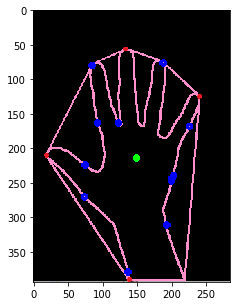

In [2]:
plt.figure(figsize=(5,5))
plt.imshow(mpimg.imread("convex hull.png"))

We need to extract the most extreme points from the contour

extLeft = tuple(hull[hull[:, :, 0].argmin()][0]) <br>
extRight = tuple(hull[hull[:, :, 0].argmax()][0]) <br>
extTop = tuple(hull[hull[:, :, 1].argmin()][0]) <br>
extBot = tuple(hull[hull[:, :, 1].argmax()][0]) <br>

Calculate center points

cX = (extLeft[0] + extRight[0]) // 2 <br>
cY = (extTop[1] + extBot[1]) // 2 <br>
cY += (cY * 0.15) <br>
cY = int(cY) <br>

Once we have the center of the palm, <br>
we can find the largest Euclidean distance between the palm center and all extreme points along the hull.

D = pairwise.euclidean_distances([(cX, cY)], Y=[extLeft, extRight, extTop, extBot])[0] <br>
maxDist = D[D.argmax()] <br>
r = int(0.7 * maxDist) <br>
circum = 2 * np.pi * r <br>

Construct the circular ROI that includes the palm + fingers

circleROI = np.zeros(thresh.shape[:2], dtype="uint8") <br>
cv2.circle(circleROI, (cX, cY), r, 255, 1) <br>
circleROI = cv2.bitwise_and(thresh, thresh, mask=circleROI) <br>

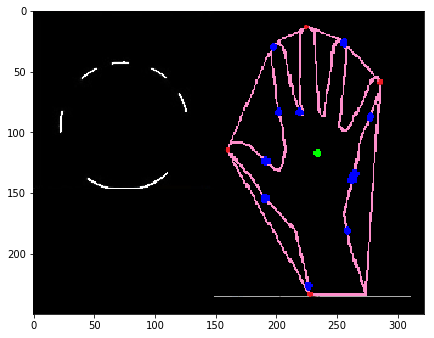

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(mpimg.imread("circleROI.png"))

As we can see above, we could know the number of fingers by counting a number of contour lines. <br>
(except the contour region at the bottom of the circle which would correspond to the wrist area) <br>

## Result

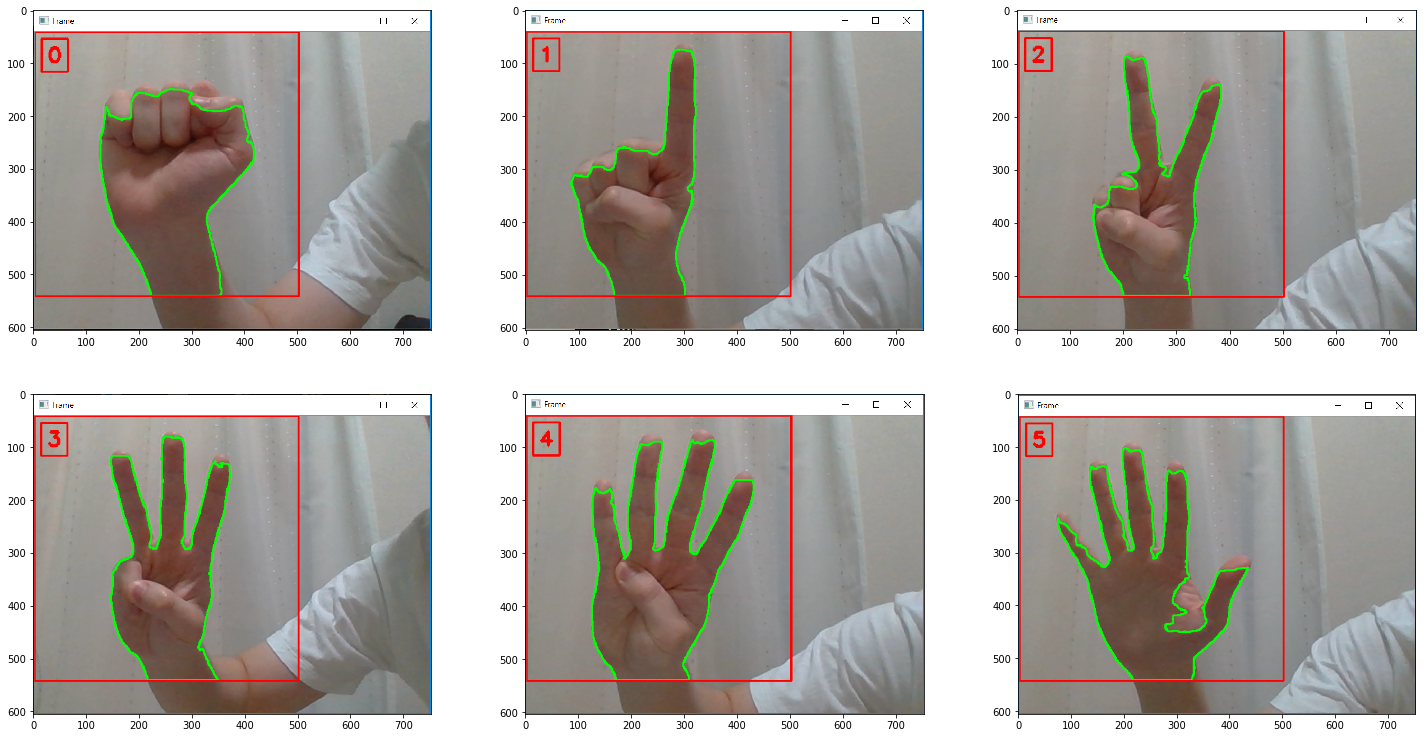

In [4]:
images = []
for img_path in glob.glob('gesture*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(25,20))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)